### Logistic Regression

Logistic regression is performed on a clinical data set with patient demographics and tumor attributes. The label is the survival status of the patient.

#### Step 1: Data Prep

The data is prepared the same way as multinomial NB, then models are compared. Continuous features are descritized, then df is one hot encoded.

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns  ## This will be for the prettier confusion matrix vis
from sklearn.metrics import confusion_matrix
import numpy as np

from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder

In [7]:
file="cleaned_cgga_693_clinical.csv"
df=pd.read_csv(file)
df.head()

,sample_id,tumor_type,tumor_histology,tumor_grade,gender,age,survival_days,survival_status,radio_status,chemo_status,mutation_status,codeletion_status
0,1002,P,anaplastic astrocyma,3,F,43.0,305.0,1.0,1.0,1.0,Wildtype,Non-codel
1,1003,P,oligodendroglioma,2,F,47.0,3817.0,0.0,0.0,1.0,Mutant,Codel
2,1010,P,astrocytoma,2,M,45.0,246.0,1.0,1.0,1.0,Mutant,Non-codel
3,1012,R,oligodendroglioma,2,M,45.0,3679.0,1.0,1.0,1.0,Mutant,Non-codel
4,1014,P,astrocytoma,2,M,42.0,263.0,1.0,0.0,1.0,Wildtype,Non-codel


In [8]:
# drop unnecessary or redundant columns
df = df.drop(columns=['sample_id','survival_days'])

In [9]:
from sklearn.preprocessing import KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df['age_binned'] = discretizer.fit_transform(df[['age']])
# retrieve bin edges to interpret output of NB model later
bin_edges = discretizer.bin_edges_[0]
print(bin_edges)
df=df.drop(columns='age', axis = 1)
df.head()

[11. 33. 40. 46. 55. 76.]


,tumor_type,tumor_histology,tumor_grade,gender,survival_status,radio_status,chemo_status,mutation_status,codeletion_status,age_binned
0,P,anaplastic astrocyma,3,F,1.0,1.0,1.0,Wildtype,Non-codel,2.0
1,P,oligodendroglioma,2,F,0.0,0.0,1.0,Mutant,Codel,3.0
2,P,astrocytoma,2,M,1.0,1.0,1.0,Mutant,Non-codel,2.0
3,R,oligodendroglioma,2,M,1.0,1.0,1.0,Mutant,Non-codel,2.0
4,P,astrocytoma,2,M,1.0,0.0,1.0,Wildtype,Non-codel,2.0


In [10]:
# use one hot encoding to tranform catagorical feautures

from sklearn.preprocessing import OneHotEncoder

#  categorical columns to encode
categorical_cols = ['tumor_type', 'tumor_histology', 'tumor_grade',
                    'gender','radio_status','chemo_status','mutation_status',
                    'codeletion_status','age_binned']  

# fit encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(df[categorical_cols])

# get the new column names
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# turn back into a DataFrame
encoded_df = pd.DataFrame(X_encoded, columns=encoded_cols, index=df.index)

# drop original columns and join the new encoded ones
df = df.drop(columns=categorical_cols).join(encoded_df)
df.head()

/Users/julianazweng/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,survival_status,tumor_type_P,tumor_type_R,tumor_histology_anaplastic astrocyma,tumor_histology_anaplastic oligoastrocytoma,tumor_histology_astrocytoma,tumor_histology_glioblastoma,tumor_histology_oligoastrocytoma,tumor_histology_oligodendroglioma,tumor_grade_2,...,chemo_status_1.0,mutation_status_Mutant,mutation_status_Wildtype,codeletion_status_Codel,codeletion_status_Non-codel,age_binned_0.0,age_binned_1.0,age_binned_2.0,age_binned_3.0,age_binned_4.0
0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Step 2: Split data into training and testing

In [11]:
training, testing = train_test_split(df, test_size=.3)
##  Save the Labels and then remove them from the Training and Testing data
training_label = training["survival_status"]
training=training.drop(["survival_status"], axis=1)
testing_label = testing["survival_status"]
testing=testing.drop(["survival_status"], axis=1)
print("Testing:", testing)

Testing:      tumor_type_P  tumor_type_R  tumor_histology_anaplastic astrocyma  \
305           1.0           0.0                                   1.0   
500           1.0           0.0                                   0.0   
35            0.0           1.0                                   0.0   
444           1.0           0.0                                   1.0   
243           1.0           0.0                                   1.0   
..            ...           ...                                   ...   
339           1.0           0.0                                   0.0   
417           0.0           1.0                                   0.0   
543           1.0           0.0                                   1.0   
151           0.0           1.0                                   1.0   
378           1.0           0.0                                   0.0   

     tumor_histology_anaplastic oligoastrocytoma  tumor_histology_astrocytoma  \
305                              

## Run Logistic Regression and display confusions matrix

In [15]:
from sklearn.linear_model import LogisticRegression

[1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.
 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.]
[[50 29]
 [16 90]]
0.7832167832167832
[[0.33254805 0.66745195]
 [0.83304123 0.16695877]
 [0.17821634 0.82178366]
 [0.2803436  0.7196564 ]
 [0.39649226 0.60350774]
 [0.11866771 0.88133229]
 [0.11573363 0.88426637]
 [0.14979821 0.85020179]
 [0.04008577 0.95991423]
 [0.57406877 0.42593123]
 [0.11573363 0.88426637]
 [0.43744166 0.56255834]
 [0.10214105 0.89785895]
 [0.20562948 0.79437052]
 [0.17489469 0.82510531]
 [0.09811696 0.90188304

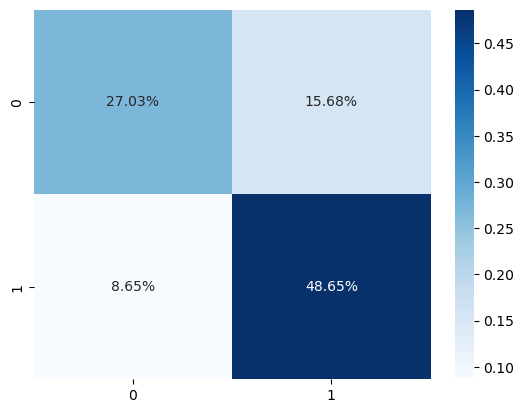

In [16]:
## Instantiate Logistic Regression (create your own copy)
MyLR = LogisticRegression()
##Perform Logistic Regression - using your copy - on the Training Data and Training Labels
My_LR_Model=MyLR.fit(training, training_label)

MyModelPredictions=My_LR_Model.predict(testing)
print(MyModelPredictions)


## Create a standard Confusion Matrix to compare the actual and predicted labels
MyCM=confusion_matrix(testing_label, MyModelPredictions)
print(MyCM)

## Use Seaborn to create a pretty confusion matrix visualization
sns.heatmap(MyCM/np.sum(MyCM), annot=True, fmt='.2%', cmap='Blues')

print(My_LR_Model.score(training, training_label))

print(My_LR_Model.predict_proba(testing))


print(My_LR_Model.coef_)
print(My_LR_Model.intercept_)




MultinomialNB()
[0. 1.]
[1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.]
The Multinomial NB Model Prediction Probabilities are:
[[0.334 0.666]
 [0.996 0.004]
 [0.085 0.915]
 [0.193 0.807]
 [0.591 0.409]
 [0.011 0.989]
 [0.009 0.991]
 [0.042 0.958]
 [0.002 0.998]
 [0.879 0.121]
 [0.009 0.991]
 [0.372 0.628]
 [0.027 0.973]
 [0.275 0.725]
 [0.049 0.951]
 [0.008 0.992]
 [0.956 0.044]
 [0.194 0.806]
 [0.003 0.997]
 [0.058 0.942]
 [0.993 0.007]
 [0.987 0.013]
 [0.919 0.081]
 [0.016 0.98

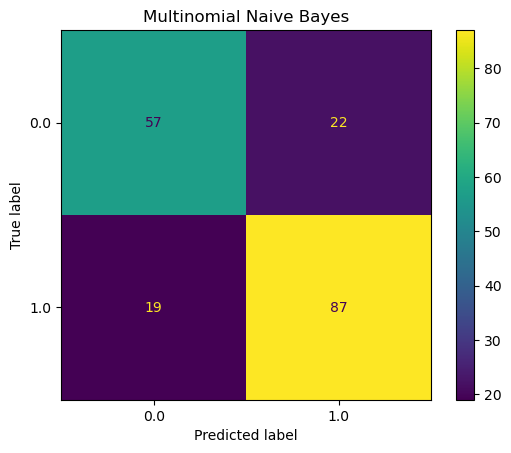

In [14]:
import matplotlib.pyplot as plt
MyMN = MultinomialNB()

## Traing the model
My_MN_Model = MyMN.fit(training, training_label)
print(My_MN_Model)
print(My_MN_Model.classes_)

## Predict the Testing Data using the model
Predictions_MN=My_MN_Model.predict(testing)
print(Predictions_MN)

## Print the actual probabilities
print("The Multinomial NB Model Prediction Probabilities are:")
print(My_MN_Model.predict_proba(testing).round(3))

## Confusion Matrix
CM_MN = confusion_matrix(testing_label, Predictions_MN)
print(CM_MN)
## Pretty confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=CM_MN,display_labels=My_MN_Model.classes_)
disp.plot()
plt.title("Multinomial Naive Bayes")
plt.show()